In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import heapq
import seaborn as sns

In [2]:
class SimulationClock:
    def __init__(self, starting_time = 0):
        self.time = starting_time
    
    def increment(self, delta):
        self.time = self.time + delta

In [3]:
class Exchange:
    def __init__(self, clock):
        self.asks = []
        self.bids = []
        self.order = namedtuple('order', ['price','t','quantity','trader','order_type'])
        # type: 0 -> marketable limit order; 1 -> market order;
        self.trades = [] 
        # time of execution; time of post; price; quantity; aggresor; passor; ag order type
        self.priority = ['price','t']
        self.clock = clock
        
    def post(self, price, quantity, trader, order_type):
        self.process_order(self.order(price, self.clock.time, quantity, trader, order_type))
        
    def get_best_ask(self):
        best_ask = heapq.nsmallest(1,self.asks)
        if best_ask == []:
            return None
        else:
            return best_ask[0]
        
    def get_best_bid(self):
        best_bid = heapq.nsmallest(1,self.bids)
        if best_bid == []:
            return None
        else:
            return best_bid[0]
        
    def process_order(self,order):
        if order.quantity > 0:
            # a bid
            price = order.price
            quantity = order.quantity
            # try to match any asks
            matching = True
            while matching:
                best_ask = self.get_best_ask()
                if best_ask == None:
                    matching = False
                else:
                    if price >= best_ask.price:
                        # order can be matched
                        trade_price = best_ask.price
                        if quantity < best_ask.quantity:
                            new_ask = best_ask._replace(quantity = best_ask.quantity - quantity)
                            heapq.heapreplace(self.asks,new_ask)
                            trade_quantity = quantity
                            quantity = 0
                            matching = False
                        elif quantity == best_ask.quantity:
                            heapq.heappop(self.asks)
                            trade_quantity = quantity
                            quantity = 0
                            matching = False
                        elif quantity > best_ask.quantity:
                            heapq.heappop(self.asks)
                            trade_quantity = best_ask.quantity
                            quantity = quantity - best_ask.quantity
                        self.trades.append((self.clock.time,best_ask.t,
                                       trade_price,trade_quantity,
                                       order.trader,best_ask.trader,1))
                    else:
                        matching = False
            # put onto order book
            if quantity != 0:
                new_bid = order._replace(price = -price, quantity = quantity)
                heapq.heappush(self.bids, new_bid)

        if order.quantity < 0:
            # an ask
            price = -order.price
            quantity = -order.quantity
            # try to match any bids
            matching = True
            while matching:
                best_bid = self.get_best_bid()
                if best_bid == None:
                    matching = False
                else:
                    if price >= best_bid.price:
                        # order can be matched
                        trade_price = -best_bid.price
                        if quantity < best_bid.quantity:
                            new_bid = best_bid._replace(quantity = best_bid.quantity - quantity)
                            heapq.heapreplace(self.bids,new_bid)
                            trade_quantity = quantity
                            quantity = 0
                            matching = False
                        elif quantity == best_bid.quantity:
                            heapq.heappop(self.bids)
                            trade_quantity = quantity
                            quantity = 0
                            matching = False
                        elif quantity > best_bid.quantity:
                            heapq.heappop(self.bids)
                            trade_quantity = best_bid.quantity
                            quantity = quantity - best_bid.quantity
                        self.lastprice = trade_price
                        self.trades.append((self.clock.time,best_bid.t,
                                       trade_price,trade_quantity,
                                       order.trader,best_bid.trader,-1))
                    else:
                        matching = False
            # put onto order book
            if quantity != 0:
                new_ask = order._replace(price = -price, quantity = quantity)
                heapq.heappush(self.asks, new_ask)

In [4]:
def bgt_scheduler( clock, FV, p_flex, lam, order_size_bound, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
    price = FV + np.random.randint(-p_flex,p_flex+1)
    heapq.heappush(event_queue,[clock.time+delta_t, price,quantity,trader,order_type])

def mm_scheduler(a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3, clock, lam, ba, bb, lastprice, depth, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    if lastprice >= ba:
        quantity = a1*(lastprice - ba) + b1*depth
        price = c1*ba + d1*depth
    elif lastprice < bb:
        quantity = a2*(bb - lastprice) + b2*depth
        price = c2*bb + d2*depth
    else:
        price = a3*lastprice + b3*depth
        quantity = c3*(ba-bb) + d3*depth
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

In [5]:
# simple order generation


events = []
FVs = []
clk = SimulationClock()
exch = Exchange(clk)
BAs = []
BBs = []
t=0

n = 1000
order_size_bound = 10
FV = 10
p_flex = 3
p_reset = 0.01
lam_bgt = 0.5
lam_mm = 0.5

event_queue = []

#init
for trader in range(0,10):

    bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

burn_in = 10



#burn_in
while clk.time < burn_in:
    # execute next event
    event = heapq.heappop(event_queue)
    event_time, price, quantity, trader, order_type = event
    clk.time = event_time
    exch.post(price, quantity, trader, order_type)
    # reset FV
    if np.random.rand(1) < p_reset:
        FV = price
    # schedule new event
    bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)
    
    # stats
    events.append([clk.time,event[2],event[1]]) 
    FVs.append(FV)
    ba = exch.get_best_ask()
    bb = exch.get_best_bid()
    if ba == None:
        ba_price = 0
    else:
        ba_price = ba.price
    if bb == None:
        bb_price = 0
    else:
        bb_price = -bb.price
    BAs.append(ba_price)
    BBs.append(bb_price)

depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

a1 = np.random.uniform(0,2,100)
a2 = np.random.uniform(0,2,100)
a3 = np.random.uniform(0,2,100)
b1 = np.random.uniform(0,2,100)
b2 = np.random.uniform(0,2,100)
b3 = np.random.uniform(0,2,100)
c1 = np.random.uniform(0,2,100)
c2 = np.random.uniform(0,2,100)
c3 = np.random.uniform(0,2,100)
d1 = np.random.uniform(0,2,100)
d2 = np.random.uniform(0,2,100)
d3 = np.random.uniform(0,2,100)


#running
for trader in range(10,110):
    k = trader - 10
    mm_scheduler(a1[k], a2[k],a3[k], b1[k], b2[k], b3[k], c1[k], c2[k], c3[k], d1[k], d2[k], d3[k], clk, lam_mm, BAs[-1], BBs[-1], exch.lastprice, depth, trader)

while clk.time < 100:
    # execute next event
    event = heapq.heappop(event_queue)
    event_time, price, quantity, trader, order_type = event
    clk.time = event_time
    exch.post(price, quantity, trader, order_type)
    # reset FV
    if np.random.rand(1) < p_reset:
        FV = price

    # stats
    events.append([clk.time,event[2],event[1]]) 
    FVs.append(FV)
    ba = exch.get_best_ask()
    bb = exch.get_best_bid()
    if ba == None:
        ba_price = 0
    else:
        ba_price = ba.price
    if bb == None:
        bb_price = 0
    else:
        bb_price = -bb.price
    BAs.append(ba_price)
    BBs.append(bb_price)
    
    depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

    # schedule new event
    if trader >= 10:
        k = trader - 10
        mm_scheduler(a1[k], a2[k],a3[k], b1[k], b2[k], b3[k], c1[k], c2[k], c3[k], d1[k], d2[k], d3[k], clk, lam_mm, BAs[-1], BBs[-1], exch.lastprice, depth, trader)
    else:
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)



# for i in range(n):
#     delta_t = np.random.exponential(lam)
#     clk.increment(delta_t)
#     quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
#     price = FV + np.random.randint(-p_flex,p_flex+1)
#     if np.random.rand(1) < p_reset:
#         FV = price
#     events.append([clk.time,quantity,price]) 

#     exch.post(price, quantity, trader, order_type)


#     FVs.append(FV)
#     ba = exch.get_best_ask()
#     bb = exch.get_best_bid()
#     if ba == None:
#         ba_price = 0
#     else:
#         ba_price = ba.price
#     if bb == None:
#         bb_price = 0
#     else:
#         bb_price = -bb.price
#     BAs.append(ba_price)
#     BBs.append(bb_price)

In [6]:
# profit calculation
trades = np.array(exch.trades)
profit=[]
for i in range(10,110):
    profit.append(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) + sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2]))
profit
    
    

[-17.907740718618005,
 -36.82403526711908,
 -173.9065104230144,
 -53.68298793445315,
 -126.97589387314939,
 -194.7762528741332,
 -94.00584619321751,
 37.462103036807704,
 -327.0858156886746,
 -229.467544060964,
 -323.7800951267003,
 -166.26939991401548,
 -39.478343350740765,
 -334.1469792579822,
 -57.324428665060346,
 -230.51651259660576,
 -58.19001066304192,
 -245.16605229387244,
 -192.87740080500134,
 -10.238544427315405,
 -92.88664252866499,
 -79.65163011031146,
 -105.67759069031707,
 -291.31324003125115,
 -115.83292562329306,
 -276.4376686678943,
 -994.7626955335365,
 -133.68375519764834,
 -165.43652653683407,
 -112.20710183807113,
 -167.94756715353216,
 -51.34694036972568,
 -180.7960745590795,
 -157.19274488404332,
 -119.53125916421635,
 -421.44301126787593,
 -235.62781008323424,
 -180.4603364476463,
 -174.77527941716204,
 -120.76084109581606,
 -257.5465084218214,
 -199.2185904967079,
 -217.11625737780423,
 -84.38057245731102,
 -608.4131080567631,
 -120.71420987044164,
 -177.40106

In [7]:
trades = np.array(exch.trades)
exch.trades

[(0.23075776077792468, 0.04094625816578069, 11, 1, 4, 1, 1),
 (0.23075776077792468, 0.006966724728697873, 12, 3, 4, 6, 1),
 (0.5247207647917582, 0.1366342996850056, 10, 1, 7, 9, -1),
 (0.5247207647917582, 0.05731202471205514, 8, 2, 7, 8, -1),
 (0.5247207647917582, 0.0792843115683829, 7, 2, 7, 9, -1),
 (0.5247207647917582, 0.5215981549852128, 7, 2, 7, 2, -1),
 (0.7739330915210197, 0.5401894812738991, 10, 6, 1, 0, -1),
 (0.8368063825955878, 0.5401894812738991, 10, 3, 1, 0, -1),
 (0.8640075842601401, 0.5215981549852128, 7, 1, 6, 2, -1),
 (1.0290343271809366, 0.9581304292930664, 9, 2, 6, 5, 1),
 (1.0290343271809366, 0.8368063825955878, 10, 2, 6, 1, 1),
 (1.0549497847568614, 0.8368063825955878, 10, 3, 3, 1, 1),
 (1.0967451144268203, 1.0670521687510606, 9, 4, 0, 7, 1),
 (1.0967451144268203, 0.8368063825955878, 10, 2, 0, 1, 1),
 (1.1545712177922491, 1.1475534941571357, 10, 3, 3, 8, -1),
 (1.34620476110992, 1.1475534941571357, 10, 5, 5, 8, -1),
 (1.34620476110992, 0.5215981549852128, 7, 1, 5, 

In [8]:
events = np.array(events)

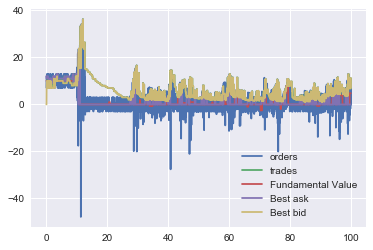

In [9]:
plt.plot(events[:,0],events[:,2], label = 'orders')
plt.plot(trades[:,0],trades[:,2], label = 'trades')
plt.plot(events[:,0],FVs, label = 'Fundamental Value')
plt.plot(events[:,0],BAs, label = 'Best ask')
plt.plot(events[:,0],BBs, label = 'Best bid')
plt.legend()

In [10]:
#list(zip(BAs,BBs))
#np.sort(np.array(exch.bids,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#np.sort(np.array(exch.asks,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#len(events)